Import Libraries

In [262]:
import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd

# For freqency graph
from matplotlib import pyplot as plt
import seaborn as sns


# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')

Libraries imported.


Purpose of this exercise is to find best place in New York City to open Spanish Restarant. We are going to get the following datapoints from http://zipatlas.com/ 

Zip Codes: New York City will be broken down into postcodes to determine the best area to establish the restaurant. http://zipatlas.com/ provides a list of zip codes for this purpose

Population by Zip Code: http://zipatlas.com/ provides population in each zip code. The higher the population, the better the target location.

Average salary per household: http://zipatlas.com/ provides average salary per household. The higher the average salary, the better the target location.

In [91]:
population_df = pd.DataFrame()

#There are 16 pages in the table
for x in range(17):
    pop_url = 'http://zipatlas.com/us/ny/zip-code-comparison/median-household-income.' + str(x+1) + '.htm'
    new_df = pd.read_html(pop_url)[10]
    new_df = new_df.rename(columns=new_df.iloc[0]).drop(new_df.index[0])
    population_df = pd.concat([population_df, new_df], axis=0)


population_df[['Latitude','Longitude']] = population_df.Location.str.split(",",expand=True)
del population_df['Location']

# Filter out non New York City zips
boroughs = ['New York, New York', 'Brooklyn, New York', 'Queens, New York', 'Bronx, New York', 'Staten Island, New York']

population_df = population_df.loc[population_df['City'].isin(boroughs)]
population_df.reset_index(drop=True, inplace=True)

Clean Up Data

In [92]:
population_df = population_df.rename(columns={'Avg. Income/H/hold': 'AvgIncome'})


# Remove rows with population of 0
population_df = population_df[population_df.Population != '0']
# Remove rows with 	Avg. Income of 0
population_df = population_df[population_df.AvgIncome != '$0.00']
population_df

,#,Zip Code,City,Population,AvgIncome,National Rank,Latitude,Longitude
0,25.,10007,"New York, New York",3522,"$112,947.00",#132,40.713973,-74.008336
1,29.,10280,"New York, New York",6614,"$108,536.00",#157,40.708501,-74.016828
2,30.,10162,"New York, New York",1726,"$108,416.00",#158,40.769298,-73.949942
3,34.,10004,"New York, New York",1225,"$101,868.00",#238,40.691870,-74.014109
4,57.,10069,"New York, New York",1403,"$88,091.00",#507,40.775551,-73.989689
...,...,...,...,...,...,...,...,...
114,1567.,10457,"Bronx, New York",69048,"$19,233.00","#30,729",40.846687,-73.898374
115,1578.,10456,"Bronx, New York",76656,"$16,664.00","#31,194",40.830877,-73.907954
116,1568.,11206,"Brooklyn, New York",69032,"$18,661.00","#30,855",40.702037,-73.942444
117,1579.,10474,"Bronx, New York",11354,"$16,339.00","#31,233",40.810203,-73.884437


Function for getting nearby food venues in a 500m radius of latitude and longitude

In [93]:
def getNearbyFoodVenues(names, latitudes, longitudes, radius=500, section = 'food'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            section, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)




Get from FourSquare all food venues in 500m radius from each zipcode latitude and longitude. Remove fast food/burger joints and focus on "Restaurant"

In [94]:
CLIENT_ID = '5R0IEDEC5CE051431E0UXETF4STAPCSPMIAXV121CUIUBF0Z' # your Foursquare ID
CLIENT_SECRET = 'WVV4D4WTSEBNZFWBDBA3KESNPUGOFEKJB0IPPII1RSF4WYXW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

ny_food = getNearbyFoodVenues(names=population_df['Zip Code'],
                                   latitudes=population_df['Latitude'],
                                   longitudes=population_df['Longitude']
                                  )

# Only focus on restarants
ny_food = ny_food[ny_food['Venue Category'].str.contains('Restaurant')]

# Remove Fast Food Places
ny_food = ny_food[ny_food['Venue Category'] != 'Fast Food Restaurant']
ny_food

10007
10280
10162
10004
10069
10282
10006
10022
10005
10024
10028
10021
10023
10128
10017
10312
10014
10016
10309
10307
10010
10011
10308
10003
10314
10012
10464
10471
11201
10019
10306
11215
11234
10044
10025
11217
10305
10018
10310
10465
10301
11231
11228
11209
11210
10303
10302
11236
10469
10304
10036
10001
10475
10463
10009
10461
11238
10470
10013
11229
11203
10466
11218
11214
10462
11222
11230
11223
11204
10033
10038
11235
11225
11220
11226
10034
10467
11232
11205
10040
10473
11208
10037
10039
10468
11219
11213
11224
10032
11216
10031
10029
10030
11207
10002
11211
11212
10472
10027
10026
11237
11239
11233
11221
10458
10460
10459
10453
10452
10454
10451
10455
10457
10456
11206
10474
10035


,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,10007,40.713973,-74.008336,Nish Nūsh,40.715537,-74.007725,Falafel Restaurant
4,10007,40.713973,-74.008336,Little Park,40.715487,-74.009133,American Restaurant
5,10007,40.713973,-74.008336,The Hummus & Pita Co,40.714453,-74.006853,Falafel Restaurant
6,10007,40.713973,-74.008336,Racines,40.714754,-74.007581,French Restaurant
8,10007,40.713973,-74.008336,Sophie's Cuban Cuisine,40.714803,-74.007656,Cuban Restaurant
...,...,...,...,...,...,...,...
4654,10035,40.795487,-73.929501,Bistro Casa Azul,40.796607,-73.932342,Mexican Restaurant
4662,10035,40.795487,-73.929501,Wing Wah Chinese Restaurant,40.797486,-73.933994,Chinese Restaurant
4666,10035,40.795487,-73.929501,La Cabana,40.796770,-73.934769,Mexican Restaurant
4667,10035,40.795487,-73.929501,Teng Dragon,40.796110,-73.935021,Chinese Restaurant


Drop na values

In [95]:
ny_food = ny_food.dropna(how='any',axis=0)
population_df

,#,Zip Code,City,Population,AvgIncome,National Rank,Latitude,Longitude
0,25.,10007,"New York, New York",3522,"$112,947.00",#132,40.713973,-74.008336
1,29.,10280,"New York, New York",6614,"$108,536.00",#157,40.708501,-74.016828
2,30.,10162,"New York, New York",1726,"$108,416.00",#158,40.769298,-73.949942
3,34.,10004,"New York, New York",1225,"$101,868.00",#238,40.691870,-74.014109
4,57.,10069,"New York, New York",1403,"$88,091.00",#507,40.775551,-73.989689
...,...,...,...,...,...,...,...,...
114,1567.,10457,"Bronx, New York",69048,"$19,233.00","#30,729",40.846687,-73.898374
115,1578.,10456,"Bronx, New York",76656,"$16,664.00","#31,194",40.830877,-73.907954
116,1568.,11206,"Brooklyn, New York",69032,"$18,661.00","#30,855",40.702037,-73.942444
117,1579.,10474,"Bronx, New York",11354,"$16,339.00","#31,233",40.810203,-73.884437


Add venue count to main dataframe of zip codes, population, avg income

In [96]:
zip_food_count = ny_food.groupby('Zip').count()
zip_food_count.reset_index(inplace=True)


merged_df = pd.merge(left=population_df, right=zip_food_count[['Zip','Venue']], how='left', left_on='Zip Code', right_on='Zip')
merged_df.reset_index(drop=True, inplace=True)  
merged_df_clean = merged_df.drop(['#', 'City', 'National Rank', 'Latitude','Longitude', 'Zip'], axis=1)
merged_df_clean

,Zip Code,Population,AvgIncome,Venue
0,10007,3522,"$112,947.00",30.0
1,10280,6614,"$108,536.00",28.0
2,10162,1726,"$108,416.00",27.0
3,10004,1225,"$101,868.00",4.0
4,10069,1403,"$88,091.00",3.0
...,...,...,...,...
112,10457,69048,"$19,233.00",5.0
113,10456,76656,"$16,664.00",5.0
114,11206,69032,"$18,661.00",15.0
115,10474,11354,"$16,339.00",3.0


Then clean the data for K-means clustering. This involves removing special characters

In [97]:
# Remove special characters and convert to floats
merged_df_clean['AvgIncome'] = merged_df_clean['AvgIncome'].str.replace('$', '')
merged_df_clean['AvgIncome'] = merged_df_clean['AvgIncome'].str.replace(',', '')
merged_df_clean['AvgIncome'] = merged_df_clean['AvgIncome'].astype(float) 
merged_df_clean['Population'] = merged_df_clean['Population'].astype(float) 

merged_df_clean

,Zip Code,Population,AvgIncome,Venue
0,10007,3522.0,112947.0,30.0
1,10280,6614.0,108536.0,28.0
2,10162,1726.0,108416.0,27.0
3,10004,1225.0,101868.0,4.0
4,10069,1403.0,88091.0,3.0
...,...,...,...,...
112,10457,69048.0,19233.0,5.0
113,10456,76656.0,16664.0,5.0
114,11206,69032.0,18661.0,15.0
115,10474,11354.0,16339.0,3.0


Remove postcodes with no venues from dataframes

In [98]:
print(merged_df_clean[merged_df_clean.isnull()['Venue']])
null_zipcode_list = list(merged_df_clean[merged_df_clean.isnull()['Venue']]["Zip Code"])

merged_df_clean = merged_df_clean[~merged_df_clean['Zip Code'].isin(null_zipcode_list)]
population_df = population_df[~population_df['Zip Code'].isin(null_zipcode_list)]
print(list(merged_df_clean['Zip Code']))
print(list(population_df['Zip Code']))

   Zip Code  Population  AvgIncome  Venue
18    10309     27207.0    65397.0    NaN
26    10464      4634.0    57458.0    NaN
27    10471     23413.0    56488.0    NaN
40    10301     38805.0    45620.0    NaN
45    10303     23530.0    42463.0    NaN
['10007', '10280', '10162', '10004', '10069', '10282', '10006', '10022', '10005', '10024', '10028', '10021', '10023', '10128', '10017', '10312', '10014', '10016', '10307', '10010', '10011', '10308', '10003', '10314', '10012', '11201', '10019', '10306', '11215', '11234', '10044', '10025', '11217', '10305', '10018', '10310', '10465', '11231', '11228', '11209', '11210', '10302', '11236', '10469', '10304', '10036', '10001', '10475', '10463', '10009', '10461', '11238', '10470', '10013', '11229', '11203', '10466', '11218', '11214', '10462', '11222', '11230', '11223', '11204', '10033', '10038', '11235', '11225', '11220', '11226', '10034', '10467', '11232', '11205', '10040', '10473', '11208', '10037', '10039', '10468', '11219', '11213', '11224', 

Remove Zip code column is preperation for clusting and normalization

In [99]:
merged_df_clustering = merged_df_clean.drop('Zip Code', 1)
merged_df_clustering

,Population,AvgIncome,Venue
0,3522.0,112947.0,30.0
1,6614.0,108536.0,28.0
2,1726.0,108416.0,27.0
3,1225.0,101868.0,4.0
4,1403.0,88091.0,3.0
...,...,...,...
112,69048.0,19233.0,5.0
113,76656.0,16664.0,5.0
114,69032.0,18661.0,15.0
115,11354.0,16339.0,3.0


Normalize each column to a value between 0 - 1 by finding the largest value in each column and dividing every element in column by largest value

In [100]:
merged_df_clustering2 = merged_df_clustering.copy()

merged_df_clustering2["Population"] = merged_df_clustering2["Population"] / merged_df_clustering2["Population"].max()
merged_df_clustering2["AvgIncome"] = merged_df_clustering2["AvgIncome"] / merged_df_clustering2["AvgIncome"].max()
merged_df_clustering2["Venue"] = merged_df_clustering2["Venue"] / merged_df_clustering2["Venue"].max()
merged_df_clustering2

,Population,AvgIncome,Venue
0,0.033178,1.000000,0.389610
1,0.062306,0.960946,0.363636
2,0.016259,0.959884,0.350649
3,0.011540,0.901910,0.051948
4,0.013217,0.779932,0.038961
...,...,...,...
112,0.650451,0.170283,0.064935
113,0.722121,0.147538,0.064935
114,0.650301,0.165219,0.194805
115,0.106958,0.144661,0.038961


Perform K-means clustering

In [101]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

merged_df_clustering2
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(merged_df_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


merged_df_clean.insert(0, 'Cluster Labels', kmeans.labels_)

Manually examine and label Cluster Group 1

In [102]:
# Low Population, Low Income, Low Venue Count
merged_df_clean[merged_df_clean['Cluster Labels'] == 0]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
82,0,10037,16984.0,26561.0,7.0
83,0,10039,21737.0,17370.0,11.0
101,0,11239,14620.0,16919.0,3.0
106,0,10459,39080.0,17498.0,3.0
109,0,10454,34976.0,14271.0,12.0
110,0,10451,40961.0,20307.0,7.0
111,0,10455,37465.0,19389.0,6.0
115,0,10474,11354.0,16339.0,3.0
116,0,10035,32702.0,14896.0,9.0


Manually examine and label Cluster Group 2

In [103]:
# High Population, Low-Medium Income
merged_df_clean[merged_df_clean['Cluster Labels'] == 1]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
31,1,11215,63001.0,53313.0,26.0
34,1,10025,97086.0,49733.0,32.0
63,1,11214,83546.0,33765.0,26.0
68,1,11204,74880.0,31798.0,21.0
69,1,10033,58259.0,31348.0,42.0
71,1,11235,77451.0,31013.0,23.0
89,1,11216,55775.0,25135.0,28.0
90,1,10031,60221.0,24285.0,26.0
91,1,10029,75390.0,22232.0,31.0
95,1,11211,85089.0,23567.0,39.0


Manually examine and label Cluster Group 3

In [104]:
# Low-Medium Population, Med-High Income, High Venue Count
merged_df_clean[merged_df_clean['Cluster Labels'] == 2]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
7,2,10022,30642.0,80406.0,65.0
10,2,10028,44987.0,77565.0,47.0
14,2,10017,16201.0,69273.0,61.0
16,2,10014,32667.0,66601.0,77.0
17,2,10016,51217.0,66342.0,65.0
20,2,10010,26408.0,62467.0,55.0
21,2,10011,46669.0,61986.0,53.0
25,2,10012,26000.0,58313.0,74.0
29,2,10019,36012.0,55869.0,60.0
37,2,10018,4255.0,48705.0,53.0


Manually examine and label Cluster Group 4

In [105]:
# Low Population, High Income
merged_df_clean[merged_df_clean['Cluster Labels'] == 3]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
0,3,10007,3522.0,112947.0,30.0
1,3,10280,6614.0,108536.0,28.0
2,3,10162,1726.0,108416.0,27.0
3,3,10004,1225.0,101868.0,4.0
4,3,10069,1403.0,88091.0,3.0
5,3,10282,1574.0,86066.0,4.0
6,3,10006,1447.0,81334.0,27.0
8,3,10005,884.0,79517.0,41.0


Manually examine and label Cluster Group 5

In [106]:
# Low-Med Population, Low-Med Income
merged_df_clean[merged_df_clean['Cluster Labels'] == 4]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
35,4,11217,35353.0,49567.0,23.0
51,4,10001,17310.0,40932.0,30.0
56,4,11238,48965.0,39917.0,31.0
70,4,10038,15574.0,31316.0,40.0
75,4,10034,41756.0,29479.0,21.0
77,4,11232,27723.0,28395.0,24.0
78,4,11205,35622.0,28070.0,31.0
92,4,10030,25847.0,17970.0,26.0
99,4,10026,30377.0,22491.0,29.0
100,4,11237,48910.0,23104.0,29.0


Manually examine and label Cluster Group 6

In [107]:
# High Population, Low-Med Income
merged_df_clean[merged_df_clean['Cluster Labels'] == 5]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
24,5,10314,84821.0,59560.0,1.0
32,5,11234,86898.0,51446.0,2.0
47,5,11236,96301.0,42370.0,6.0
59,5,11229,80554.0,37812.0,16.0
60,5,11203,84498.0,37341.0,8.0
62,5,11218,74611.0,36432.0,12.0
66,5,11230,88933.0,32327.0,7.0
67,5,11223,77691.0,32104.0,13.0
73,5,11220,92718.0,30152.0,15.0
74,5,11226,106154.0,29498.0,9.0


Manually examine and label Cluster Group 7. 
# This is the best cluster for fit

In [108]:
# High Population, Medium-High Income, High Venue Count
merged_df_clean[merged_df_clean['Cluster Labels'] == 6]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
9,6,10024,61414.0,78066.0,32.0
11,6,10021,102078.0,75472.0,41.0
12,6,10023,62206.0,72424.0,60.0
13,6,10128,59856.0,70031.0,49.0
23,6,10003,53673.0,60891.0,60.0
43,6,11209,69840.0,44518.0,55.0
54,6,10009,58595.0,40176.0,58.0
94,6,10002,84870.0,24022.0,57.0


Manually examine and label Cluster Group 8

In [109]:
# Low Population, Medium Income, Low Venue Count
merged_df_clean[merged_df_clean['Cluster Labels'] == 7]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
19,7,10307,11669.0,64159.0,7.0
22,7,10308,26451.0,61868.0,9.0
33,7,10044,9520.0,49976.0,5.0
38,7,10310,22852.0,46198.0,3.0
46,7,10302,16406.0,42452.0,2.0
57,7,10470,15780.0,38464.0,8.0


Manually examine and label Cluster Group 9

In [110]:
# High Population, Low-Medium Income
merged_df_clean[merged_df_clean['Cluster Labels'] == 8]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
44,8,11210,62308.0,42967.0,12.0
48,8,10469,63345.0,42102.0,4.0
53,8,10463,65576.0,40497.0,9.0
61,8,10466,68787.0,37141.0,3.0
64,8,10462,72077.0,33735.0,8.0
72,8,11225,63774.0,30192.0,18.0
79,8,10040,46599.0,27905.0,14.0
80,8,10473,56166.0,27733.0,2.0
86,8,11213,65440.0,26366.0,12.0
87,8,11224,51205.0,21281.0,3.0


Manually examine and label Cluster Group 10

In [111]:
# Medium Population, Medium Income, Low Venue Count
merged_df_clean[merged_df_clean['Cluster Labels'] == 9]

,Cluster Labels,Zip Code,Population,AvgIncome,Venue
15,9,10312,58867.0,67728.0,2.0
28,9,11201,47746.0,56293.0,11.0
30,9,10306,55698.0,55413.0,3.0
36,9,10305,38450.0,48944.0,2.0
39,9,10465,42500.0,45650.0,13.0
41,9,11231,32974.0,45154.0,4.0
42,9,11228,41172.0,44932.0,5.0
49,9,10304,38972.0,41041.0,1.0
52,9,10475,38086.0,40528.0,2.0
55,9,10461,49808.0,40024.0,7.0


The selected postcode will be the one that has the lowest [Restaurant] / [Population] number. This will represent the postcode that has the lowest number of restaurants to cater to the local population.

In [113]:
selected_cluster = merged_df_clean[merged_df_clean['Cluster Labels'] == 6].copy()
selected_cluster['Venue Ratio'] = selected_cluster['Venue'] / selected_cluster['Population']
selected_cluster.sort_values(by=['Venue Ratio'])

,Cluster Labels,Zip Code,Population,AvgIncome,Venue,Venue Ratio
11,6,10021,102078.0,75472.0,41.0,0.000402
9,6,10024,61414.0,78066.0,32.0,0.000521
94,6,10002,84870.0,24022.0,57.0,0.000672
43,6,11209,69840.0,44518.0,55.0,0.000788
13,6,10128,59856.0,70031.0,49.0,0.000819
12,6,10023,62206.0,72424.0,60.0,0.000965
54,6,10009,58595.0,40176.0,58.0,0.000990
23,6,10003,53673.0,60891.0,60.0,0.001118


# So Post Code 10021 is the best target post code for Restaurant

Check to make sure no other Spanish Restaurants are in post code 

In [128]:
ny_food[ny_food['Zip'] == '10021']["Venue Category"].str.contains("Spain")

638    False
639    False
640    False
641    False
642    False
645    False
646    False
649    False
650    False
652    False
653    False
654    False
657    False
658    False
659    False
661    False
662    False
663    False
666    False
668    False
670    False
671    False
674    False
675    False
676    False
677    False
678    False
681    False
682    False
683    False
684    False
685    False
686    False
688    False
689    False
690    False
691    False
693    False
695    False
703    False
706    False
Name: Venue Category, dtype: bool

Get list of non-food venues to determine best street in zip code  10021

In [194]:
# Get Latitude and Longitude of 10021
lat_10021 = population_df[population_df['Zip Code'] == '10021'].iloc[0]['Latitude']
long_10021 = population_df[population_df['Zip Code'] == '10021'].iloc[0]['Longitude']

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&section={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_10021, 
            long_10021,
            500, 
            'drinks',
            'coffee',
            'shop',
            LIMIT)
# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '57124d59cd103d006f6bb417',
   'name': 'Flying Tiger Copenhagen',
   'location': {'address': '1283 3rd Ave',
    'crossStreet': 'at 73rd St',
    'lat': 40.770898319516576,
    'lng': -73.95993055564092,
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.770898319516576,
      'lng': -73.95993055564092}],
    'distance': 194,
    'postalCode': '10021',
    'cc': 'US',
    'neighborhood': 'Upper East Side',
    'city': 'New York',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['1283 3rd Ave (at 73rd St)',
     'New York, NY 10021',
     'United States']},
   'categories': [{'id': '4bf58dd8d48988d128951735',
     'name': 'Gift Shop',
     'pluralName': 'Gift Shops',
     'shortName': 'Gift Shop',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/giftshop_',
      'suf

In [257]:
# return only relevant information for each nearby venue
venues_list=[]
# some elements dont have the field Address so we need to use formattedAddress
venues_list.append([(
            '10021', 
            v['venue']['name'], 
            v['venue']['location']['formattedAddress'], 
            v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Zip', 
                  'Venue', 
                  'Address', 
                  'Venue Category']

street_list = list(nearby_venues['Address'])

street_df = pd.DataFrame(columns = ['Street'])
street_df

for i in street_list:
    address = i[0].split()

    # Get rid of street number which is first element
    if address[0].isdigit():
        address.pop(0)

    trimmed_address = ''
    for j in address:
        
        # Clean up junk strings
        if j.startswith('('):
            break
        
        if j.startswith('Fl'):
            break
            
        if j.startswith('Ste'):
            break

        if j.startswith('New'):
            break
            
        if j == 'Avenue':
            j = 'Ave'  
            
        trimmed_address = trimmed_address + j + ' '
    
    new_row = {'Street':trimmed_address}

    street_df = street_df.append(new_row, ignore_index=True)

street_df

,Street
0,3rd Ave
1,3rd Ave
2,E 72nd St
3,3rd Ave
4,3rd Ave
...,...
74,Madison Ave
75,Madison Ave
76,2nd Ave
77,2nd Ave


Create Histogram

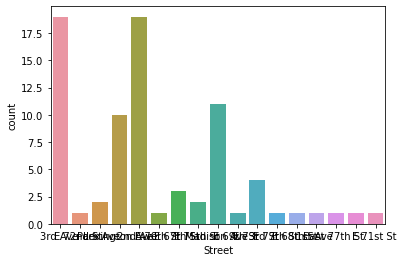

In [260]:

ax = sns.countplot(x="Street",data=street_df)
